<a href="https://colab.research.google.com/github/IFuentesSR/SAMSARA_UAI/blob/main/Deforested_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=dLeJioSemHS5HqcV3xpLvY_r0FWV6uFxiOsrOy27nkA&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWh-4YF8GLhrs1QHZS4SSkjkS1UXCiiziUWbXCoUZ0PkZUjH-cmOdeI

Successfully saved authorization token.


In [ ]:
# Folium setup.
import folium
import datetime
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import interpolate
import plotly.express as px


print(folium.__version__)

0.8.3


In [ ]:
def getS2_CLOUD_PROBABILITY(geo):
    innerJoined = ee.Join.inner().apply(primary=ee.ImageCollection("COPERNICUS/S2").filterBounds(geo).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)),
                                        secondary=ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY").filterBounds(geo),
                                        condition=ee.Filter.equals(leftField='system:index',
                                                                   rightField='system:index'))
    def mergeImageBands(joinResult):
        return ee.Image(joinResult.get('primary')).addBands(joinResult.get('secondary'))

    newCollection = innerJoined.map(mergeImageBands)
    return ee.ImageCollection(newCollection)


def projectShadows(cloudMask, sunAzimuth, offset):
    azimuth = ee.Number(sunAzimuth).multiply(np.pi).divide(180.0).add(ee.Number(0.5).multiply(np.pi))
    x = azimuth.cos().multiply(15.0).round();
    y = azimuth.sin().multiply(15.0).round();
    shadow = cloudMask.changeProj(cloudMask.projection(), cloudMask.projection().translate(x.multiply(ee.Number(offset)), y.multiply(ee.Number(offset))))
    return shadow


def scale(img):
    props = img.propertyNames()
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    ob = ['B1', 'B9', 'B10', 'probability']
    scaled = img.select(bands).divide(10000)
    return scaled.addBands(img.select(ob)).copyProperties(img, props)


def masking(img):
    props = img.propertyNames()
    img_scaled = ee.Image(scale(img))
    clouds = img_scaled.select('probability').gte(30)
    shadows = projectShadows(clouds,
                             img_scaled.get('MEAN_SOLAR_AZIMUTH_ANGLE'), 
                             img.get('MEAN_INCIDENCE_ZENITH_ANGLE_B10'))
    shadow_distance = shadows.fastDistanceTransform().sqrt()

    shadow_dilation = shadow_distance.lt(5)
    mask = clouds.Not().multiply(shadow_dilation.Not())
    return img_scaled.updateMask(mask).copyProperties(img_scaled, props)


def getNDVI(img):
    props = img.propertyNames()
    return img.normalizedDifference(['B8', 'B4']).copyProperties(img, props)


def set_date(date):
    def inner(i):
        return i.set('date', date)
    return inner


def set_date2(img):
    return img.set('date', ee.Date(img.get('system:time_start')).format('YYYY-MM-dd'))


In [ ]:
geometry2 = ee.Geometry.Polygon([[[-70.44254253478202, -33.591345019471],
                                  [-70.5455393609539, -33.60507142367403],
                                  [-70.90396831603202, -33.68052757973258],
                                  [-71.09622905821952, -33.89738018040196],
                                  [-71.04267070861015, -34.09321453297721],
                                  [-70.35739849181327, -34.003323413301764],
                                  [-70.25302837462577, -33.803858533866645],
                                  [-70.26813457579765, -33.622226356345],
                                  [-70.37250469298515, -33.59592073027944],
                                  [-70.40409038634452, -33.648523953879206]]])
samples = ee.FeatureCollection('users/ignaciofuentessanroman/deforestedSamples')
print(samples.size().getInfo())

55


In [ ]:
s2 = getS2_CLOUD_PROBABILITY(geometry2).map(masking)
ndvis = s2.map(getNDVI).map(set_date2)
dates = ndvis.aggregate_array('date').distinct()


In [ ]:
def sample_regions(fc):
    def inner(img):
        footprint = ee.Geometry.Polygon(ee.Geometry(img.get('system:footprint')).coordinates())
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
        def inner2(fea):
            intersect = fea.intersection(footprint)
            area_intersection = intersect.area(1)
            ratio = area_intersection.divide(fea.area(1))
            ndvi = img.reduceRegion('median', fea.geometry(), 30).values().get(0)
            return ee.Feature(None, 
                              {'id': fea.get('id'),
                               'date':date,
                               'ndvi':ndvi,
                               'ratio':ratio})
        vals = fc.map(inner2)
        return vals
    return inner

In [ ]:
# def mosaic_by_date(ndvis):
#     def inner(date):
#         date0 = ee.Date(date)
#         collection = ndvis.filterDate(date0, date0.advance(1, 'day'))
#         img = collection.first()
#         props = img.propertyNames()
#         mosaic = collection.mean()
#         return mosaic.copyProperties(img, props)
#     return inner


In [ ]:
# mosaic_ndvi = dates.map(mosaic_by_date(ndvis))

In [ ]:
# mosaic_ndvi = ee.ImageCollection.fromImages(mosaic_ndvi).sort('system:time_start')

In [ ]:
# mosaic_ndvi.getInfo()

In [ ]:
geo = ee.Feature(samples.filter(ee.Filter.eq('id', '10')).first())
id = geo.getMapId() 
s2_2018 = s2.filterDate('2018-01-01', '2019-01-01').mean().getMapId({'bands':['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
s2_2021 = s2.filterDate('2021-01-01', '2022-01-01').mean().getMapId({'bands':['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
centroid = geo.centroid().getInfo()['geometry']['coordinates'][::-1]
map = folium.Map(location=centroid, zoom_start=16)
folium.TileLayer(
    tiles=s2_2018['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='s2_2018',
  ).add_to(map)
folium.TileLayer(
    tiles=s2_2021['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='s2_2021',
  ).add_to(map)
folium.TileLayer(
    tiles=id['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='feature',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [ ]:
data = ee.FeatureCollection(ndvis.map(sample_regions(samples.limit(10)))).flatten().filter(ee.Filter.gt('ratio', 0.5)).getInfo()

In [ ]:
ndvi = [n['properties']['ndvi'] if 'ndvi' in n['properties'] else np.nan for n in data['features']]
dates = pd.to_datetime([n['properties']['date'] for n in data['features']])
ids = [n['properties']['id'] for n in data['features']]
ratios = [n['properties']['ratio'] for n in data['features']]
df = pd.DataFrame(data={'ndvi':ndvi, 'date':dates, 'id':ids, 'ratio':ratios})
df = df.dropna(how='any')

In [28]:
for n in df.id.unique():
    sub_df = df[df['id'] == n]
    sub_df = sub_df.sort_values('date')
    fig = px.scatter(sub_df, x='date', y='ndvi')
    fig.show()

    # plt.scatter(sub_df['date'], sub_df['ndvi'])
    # plt.show()

# Seasonal decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
ixs = df.id.unique()
ixs
sub_df = df[df['id'] == ixs[0]]
sub_df = sub_df.set_index('date')
sub_df.sort_index(inplace=True)
sub_df = sub_df[~sub_df.index.duplicated(keep='first')]
sub_df = sub_df.resample('15D').mean()
sub_df = sub_df[['ndvi']].interpolate(method='linear',limit=3)
sub_df.dropna(how='any', inplace=True)



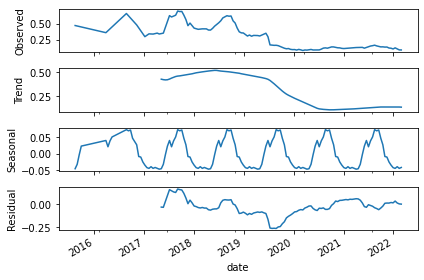

In [ ]:
sd = seasonal_decompose(sub_df[['ndvi']], 'additive', freq=24, two_sided=False)
sd.plot()
plt.show()

In [ ]:
2 * sub_df.std()

ndvi    0.368518
dtype: float64

# Isolation Forest

In [ ]:
sub_df.reset_index(inplace=True)
sub_df['doy'] = sub_df['date'].dt.dayofyear
sub_df['year'] = sub_df['date'].dt.year
sub_df['month'] = sub_df['date'].dt.month

In [ ]:
iso_forest = IsolationForest(contamination=0.004, max_features=4, max_samples=0.8, n_estimators=200)
iso_forest.fit(sub_df[['doy', 'year', 'month', 'ndvi']])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



IsolationForest(contamination=0.004, max_features=4, max_samples=0.8,
                n_estimators=200)

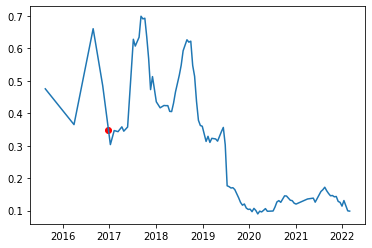

In [ ]:
sub_df.loc[:, 'out'] = pd.Series(iso_forest.predict(sub_df.reset_index()[['doy', 'year', 'month', 'ndvi']])).apply(lambda x: 1 if (x == -1) else 0)
plt.plot(sub_df['date'], sub_df.ndvi)
plt.scatter(pd.to_datetime(sub_df[sub_df['out'] == 1]['date'].values),
            sub_df[sub_df['out'] == 1]['ndvi'].values.tolist(), c='red')

# Ruptures

In [ ]:
!pip install ruptures

     |████████████████████████████████| 991 kB 9.9 MB/s 


In [ ]:
import ruptures as rpt

In [ ]:
sub_df

,date,ndvi,doy,year,month,out
0,2015-08-18,0.475448,230,2015,8,0
1,2015-09-02,0.468089,245,2015,9,0
2,2015-09-17,0.460730,260,2015,9,0
3,2015-10-02,0.453371,275,2015,10,0
4,2016-03-30,0.365065,90,2016,3,0
...,...,...,...,...,...,...
137,2021-12-29,0.113538,363,2021,12,0
138,2022-01-13,0.130816,13,2022,1,0
139,2022-01-28,0.114921,28,2022,1,0
140,2022-02-12,0.099026,43,2022,2,0


In [ ]:
n_breaks = 1

In [ ]:
def proc_df(df, ix):
    sub_df = df[df['id'] == ix]
    sub_df = sub_df.set_index('date')
    sub_df.sort_index(inplace=True)
    sub_df = sub_df[~sub_df.index.duplicated(keep='first')]
    sub_df = sub_df.resample('15D').mean()
    sub_df.reset_index(inplace=True)
    sub_df['ndvi'] = sub_df['ndvi'].interpolate(method='linear',limit=5)
    return sub_df


def model_breaks(df):
    # model = rpt.Dynp(model="l1")
    model = rpt.KernelCPD(kernel='rbf')
    model.fit(df['ndvi'].values)
    return model    

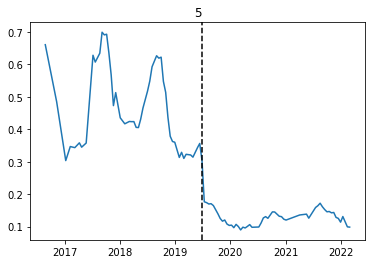

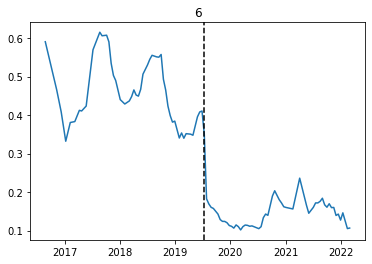

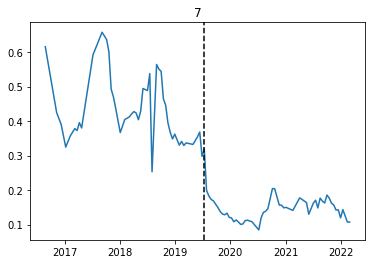

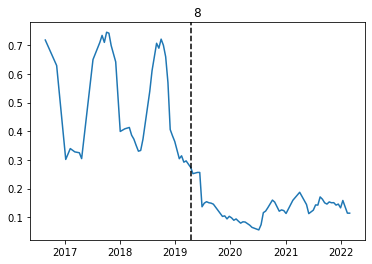

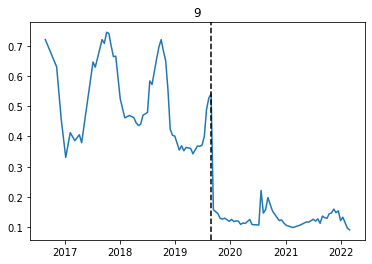

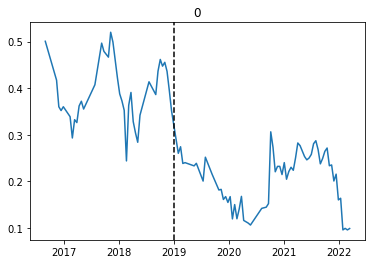

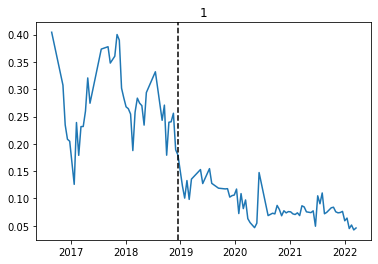

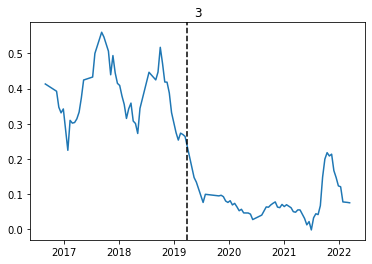

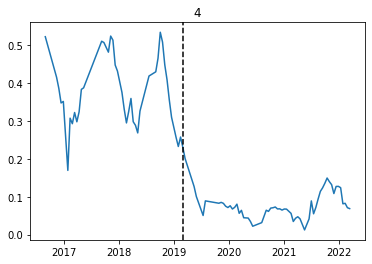

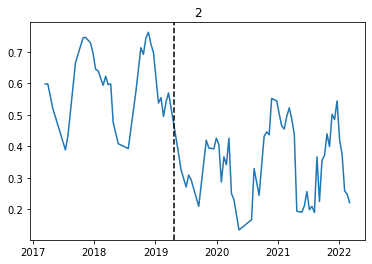

In [ ]:
for n in df.id.unique():
    sub_df = proc_df(df, n)
    sub_df2 = sub_df.loc[25:, ['date', 'ndvi']]
    model = model_breaks(sub_df2)
    breaks = model.predict(n_bkps=n_breaks)
    dates = [sub_df2.iloc[n-1]['date'] for n in breaks[:-1]]
    plt.plot(sub_df2['date'], sub_df2['ndvi'])
    for x in dates:
        plt.axvline(x, color='black', ls='--')
    plt.title(n)
    plt.show()


# Sentinel 1 (SAR)

In [31]:
# https://hal.archives-ouvertes.fr/hal-01249995/document
def toNatural(img):
    img = ee.Image(img)
    return ee.Image(10.0).pow(img.select(['VV_RLSF', 'VH_RLSF']).divide(10.0))


def toDB(img):
    img = ee.Image(img)
    return ee.Image(img).log10().multiply(10.0).copyProperties(img, ['system:time_start', 'date'])


def edgeRemoval(img):
    img = ee.Image(img)
    return img.updateMask(img.gt(-30))


def RefinedLee(img):
    img = ee.Image(img)
    # img must be in natural units, i.e. not in dB!
    # Set up 3x3 kernels 
    weights3 = ee.List.repeat(ee.List.repeat(1,3),3)
    kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False)

    mean3 = img.reduceNeighborhood(ee.Reducer.mean(), kernel3)
    variance3 = img.reduceNeighborhood(ee.Reducer.variance(), kernel3)

    # Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
    sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],
                              [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],
                              [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],
                              [0,0,0,0,0,0,0]])

    sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False)

    # Calculate mean and variance for the sampled windows and store as 9 bands
    sample_mean = mean3.neighborhoodToBands(sample_kernel)
    sample_var = variance3.neighborhoodToBands(sample_kernel)

    # Determine the 4 gradients for the sampled windows
    gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs()
    gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs())
    gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs())
    gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs())

    # And find the maximum gradient amongst gradient bands
    max_gradient = gradients.reduce(ee.Reducer.max())

    # Create a mask for band pixels that are the maximum gradient
    gradmask = gradients.eq(max_gradient)

    # duplicate gradmask bands: each gradient represents 2 directions
    gradmask = gradmask.addBands(gradmask)

    # Determine the 8 directions
    directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1)
    directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2))
    directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3))
    directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4))
    # The next 4 are the not() of the previous 4
    directions = directions.addBands(directions.select(0).Not().multiply(5))
    directions = directions.addBands(directions.select(1).Not().multiply(6))
    directions = directions.addBands(directions.select(2).Not().multiply(7))
    directions = directions.addBands(directions.select(3).Not().multiply(8))

    # Mask all values that are not 1-8
    directions = directions.updateMask(gradmask)

    # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
    directions = directions.reduce(ee.Reducer.sum())

    sample_stats = sample_var.divide(sample_mean.multiply(sample_mean))

    # Calculate localNoiseVariance
    sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0])

    # Set up the 7*7 kernels for directional statistics
    rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4))

    diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0], 
                            [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], 
                            [1,1,1,1,1,1,1]])

    rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False)
    diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False)

    # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
    dir_mean = img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1))
    dir_var = img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1))

    dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)))
    dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)))

    # and add the bands for rotated kernels
    # for (var i=1; i<4; i++) {
    #   dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)));
    #   dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)));
    #   dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)));
    #   dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)));
    # }
    for i in range(1, 4):
        dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
        dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

    # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
    dir_mean = dir_mean.reduce(ee.Reducer.sum())
    dir_var = dir_var.reduce(ee.Reducer.sum())

    # A finally generate the filtered value
    varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))

    b = varX.divide(dir_var)

    result = dir_mean.add(b.multiply(img.subtract(dir_mean)))
    return(result.arrayFlatten([['sum']])).copyProperties(img, ['system:time_start']).set('date', ee.Date(img.get('system:time_start')).format('YYYY-MM-dd'))


def leesf(img):
    props = img.propertyNames()
    VV = ee.Image(edgeRemoval(toDB(RefinedLee(img.select('VV'))))).rename('VV_RLSF')
    VH = ee.Image(edgeRemoval(toDB(RefinedLee(img.select('VH'))))).rename('VH_RLSF')
    return VV.addBands(VH).addBands(img.select('angle').rename('angle')).copyProperties(img, props)



def coll2nat(img):
    props = img.propertyNames()
    img = ee.Image(img)
    angle = img.select('angle')
    return ee.Image(toNatural(img)).addBands(angle.rename('angle')).copyProperties(img, props)


def coll2db(img):
    props = img.propertyNames()
    img = ee.Image(img)
    angle = img.select('angle')
    return ee.Image(toDB(img)).addBands(angle.rename('angle')).copyProperties(img, props)


def rviFunction(img):
    #https://www.tandfonline.com/doi/full/10.1080/22797254.2021.2018667
    props = img.propertyNames()
    rvi = img.select('VH_RLSF').multiply(4).divide(img.select('VH_RLSF').add(img.select('VV_RLSF')))
    return rvi.copyProperties(img, props)


def get_lia_descending(img):
    s1_inc = img.select('angle')
    s1_azimuth = ee.Terrain.aspect(s1_inc).reduceRegion(ee.Reducer.mean(), s1_inc.get('system:footprint'), 100).get('aspect')
    def getDESCCorners(f):
        coords = ee.Array(f.geometry().coordinates().get(0)).transpose()
        crdLons = ee.List(coords.toList().get(0))
        crdLats = ee.List(coords.toList().get(1))
        minLon = crdLons.sort().get(0)
        maxLon = crdLons.sort().get(-1)
        minLat = crdLats.sort().get(0)
        maxLat = crdLats.sort().get(-1)
        azimuth = ee.Number(crdLons.get(crdLats.indexOf(minLat))).subtract(minLon).atan2(ee.Number(crdLats.get(crdLons.indexOf(minLon))).subtract(minLat)).multiply(180.0/np.pi).add(180.0)
        return ee.Feature(ee.Geometry.LineString([crdLons.get(crdLats.indexOf(maxLat)), 
                                                  maxLat,
                                                  minLon,
                                                  crdLats.get(crdLons.indexOf(minLon))]),
                          { 'azimuth': azimuth}).copyProperties(f)
    azimuthEdge = getDESCCorners(img)
    trueAzimuth = azimuthEdge.get('azimuth')
    rotationFromSouth = ee.Number(trueAzimuth).subtract(180.0)
    s1_azimuth = ee.Number(s1_azimuth).add(rotationFromSouth)
    srtm = ee.Image('USGS/SRTMGL1_003').clip(ee.Geometry.Polygon(ee.Geometry(s1_inc.get('system:footprint')).coordinates()))
    srtm_slope = ee.Terrain.slope(srtm).select('slope')
    srtm_aspect = ee.Terrain.aspect(srtm).select('aspect')
    slope_projected2 = srtm_slope.multiply(ee.Image.constant(trueAzimuth).subtract(90.0).subtract(srtm_aspect).multiply(np.pi/180).cos())
    lia2 = s1_inc.subtract(ee.Image.constant(90).subtract(ee.Image.constant(90).subtract(slope_projected2))).abs()
    return img.addBands(lia2.rename('LIA'))


def toGamma0(image):
    normal = image.select(0).divide(image.select('LIA').multiply(np.pi/180.0).cos())
    return normal.copyProperties(image)


def gammaBoth(ig):
    ig = ee.Image(ig)
    props = ig.propertyNames()
    VV = ee.Image(toGamma0(get_lia_descending(ig.select(['VV_RLSF', 'angle']))))
    VH = ee.Image(toGamma0(get_lia_descending(ig.select(['VH_RLSF', 'angle']))))
    return VV.addBands(VH).copyProperties(ig, props)



In [43]:
S1 = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
S1 = S1.filterBounds(geometry2)
S1 = S1.filter(ee.Filter.eq('instrumentMode', 'IW'))
S1 = S1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
S1 = S1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
S1 = S1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
# S1 = S1.filter(ee.Filter.eq('platform_number', 'B'))

## RVI - Radar Vegetation Index

In [44]:
S1 = S1.map(leesf)
S1 = S1.map(coll2nat)
SRI = S1.map(rviFunction)

In [45]:
data_sri = ee.FeatureCollection(SRI.map(sample_regions(samples.limit(10)))).flatten().filter(ee.Filter.gt('ratio', 0.5)).getInfo()

In [46]:
# data_vv = ee.FeatureCollection(S1.select('VV_RLSF').map(sample_regions(samples.limit(10)))).flatten().filter(ee.Filter.gt('ratio', 0.5)).getInfo()

In [47]:
# data_vh = ee.FeatureCollection(S1.select('VH_RLSF').map(sample_regions(samples.limit(10)))).flatten().filter(ee.Filter.gt('ratio', 0.5)).getInfo()

In [48]:
def rat(img):
    img = ee.Image(img)
    props = img.propertyNames()
    vh = img.select('VH_RLSF')
    vv = img.select('VV_RLSF')
    return vv.divide(vh).copyProperties(img, props)

# data_ratio = ee.FeatureCollection(S1.map(rat).map(sample_regions(samples.limit(10)))).flatten().filter(ee.Filter.gt('ratio', 0.5)).getInfo()

In [49]:
sri = [n['properties']['ndvi'] if 'ndvi' in n['properties'] else np.nan for n in data_sri['features']]
dates = pd.to_datetime([n['properties']['date'] for n in data_sri['features']])
ids = [n['properties']['id'] for n in data_sri['features']]
ratios = [n['properties']['ratio'] for n in data_sri['features']]
df_sri = pd.DataFrame(data={'sri':sri, 'date':dates, 'id':ids, 'ratio':ratios})
df_sri = df_sri.dropna(how='any')

In [ ]:
df_sri

,sri,date,id,ratio
0,0.314571,2014-10-16,0,1
1,0.372151,2014-10-16,1,1
2,1.088878,2014-10-16,2,1
3,0.911236,2014-10-16,3,1
4,1.007991,2014-10-16,4,1
...,...,...,...,...
2635,0.390287,2021-12-20,5,1
2636,0.230847,2021-12-20,6,1
2637,0.323639,2021-12-20,7,1
2638,0.413436,2021-12-20,8,1


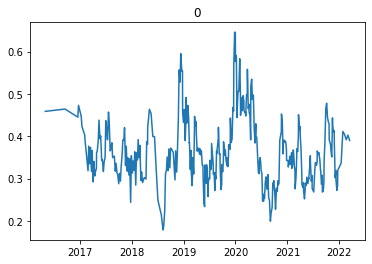

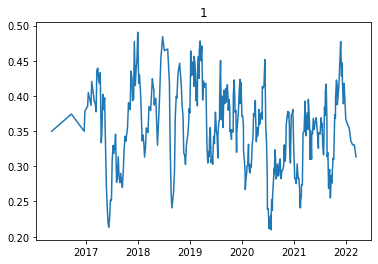

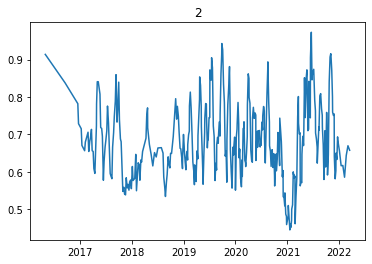

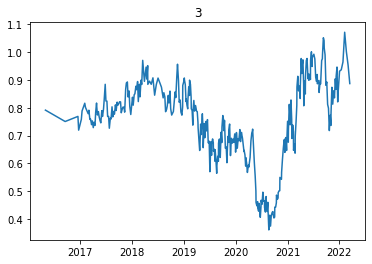

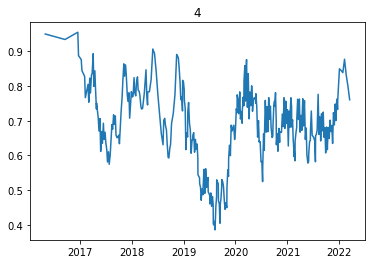

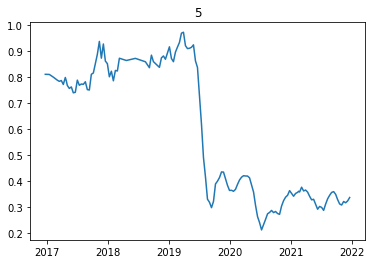

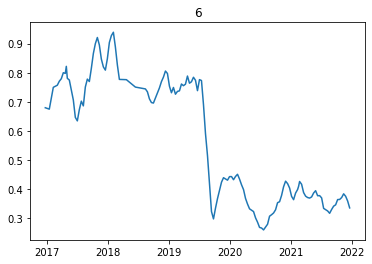

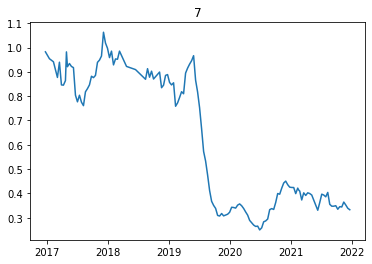

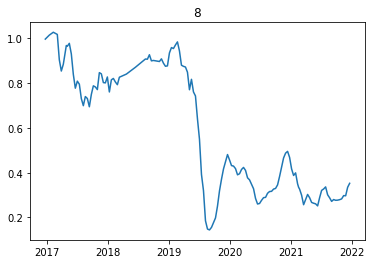

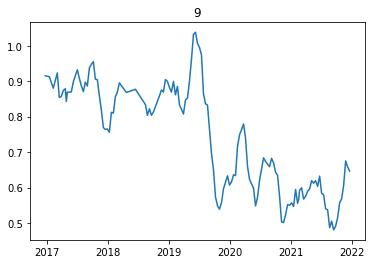

In [51]:
for n in df_sri.id.unique():
    subdf = df_sri[df_sri['id'] == n]
    subdf = subdf.sort_values('date')
    subdf2 = subdf.groupby('date').mean()
    subdf2['roll'] = subdf2['sri'].rolling(5).mean()
    plt.plot(subdf2[['roll']])
    plt.title(n)
    plt.show()

### VV polarization

In [52]:
# vv = [n['properties']['ndvi'] if 'ndvi' in n['properties'] else np.nan for n in data_vv['features']]
# dates = pd.to_datetime([n['properties']['date'] for n in data_vv['features']])
# ids = [n['properties']['id'] for n in data_vv['features']]
# ratios = [n['properties']['ratio'] for n in data_vv['features']]
# df_vv = pd.DataFrame(data={'vv':vv, 'date':dates, 'id':ids, 'ratio':ratios})
# df_vv = df_vv.dropna(how='any')

# for n in df_vv.id.unique():
#     subdf = df_vv[df_vv['id'] == n]
#     subdf = subdf.sort_values('date')
#     subdf2 = subdf.groupby('date').mean()
#     plt.plot(subdf2[['vv']])
#     plt.title(n)
#     plt.show()

### VH polarization

In [53]:
# vh = [n['properties']['ndvi'] if 'ndvi' in n['properties'] else np.nan for n in data_vh['features']]
# dates = pd.to_datetime([n['properties']['date'] for n in data_vh['features']])
# ids = [n['properties']['id'] for n in data_vh['features']]
# ratios = [n['properties']['ratio'] for n in data_vh['features']]
# df_vh = pd.DataFrame(data={'vh':vh, 'date':dates, 'id':ids, 'ratio':ratios})
# df_vh = df_vh.dropna(how='any')

# for n in df_vh.id.unique():
#     subdf = df_vh[df_vh['id'] == n]
#     subdf = subdf.sort_values('date')
#     subdf2 = subdf.groupby('date').mean()
#     plt.plot(subdf2[['vh']])
#     plt.title(n)
#     plt.show()

### Ratio polarization

In [54]:
# rats = [n['properties']['ndvi'] if 'ndvi' in n['properties'] else np.nan for n in data_ratio['features']]
# dates = pd.to_datetime([n['properties']['date'] for n in data_ratio['features']])
# ids = [n['properties']['id'] for n in data_ratio['features']]
# ratios = [n['properties']['ratio'] for n in data_ratio['features']]
# df_ratio = pd.DataFrame(data={'rat':rats, 'date':dates, 'id':ids, 'ratio':ratios})
# df_ratio = df_ratio.dropna(how='any')

# for n in df_ratio.id.unique():
#     subdf = df_ratio[df_ratio['id'] == n]
#     subdf = subdf.sort_values('date')
#     subdf2 = subdf.groupby('date').mean()
#     plt.plot(subdf2[['rat']])
#     plt.title(n)
#     plt.show()